In [1]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union
from pandas.plotting import register_matplotlib_converters
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union
from pandas.tseries.offsets import MonthEnd

ee.Initialize()

register_matplotlib_converters()
ee.Initialize()


In [12]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied, currently works for 2000 - 2018
3) Scale (optional): Resolution at which to perform analysis (if not specified, calculated automatically in EE)
4) Satellites / datasets: Queried from Earth Engine, defined in data[sat1...] 
'''

##### AREA #####

# CV
cv = gp.read_file("../shape/cv.shp")
cv_km3 = round(cv.area[0] * 10, 2)* 1000

# HUC 4s draining to the CV 
ssjt = gp.read_file("../shape/cv_hu6.shp")
ssjt2 = ssjt.geometry.simplify(0.1) # This reduces the # of geometries submitted to EE and makes things run mucho faster 
lls = ssjt2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)

# Get the area of the ssjt wshed 
s1 = gp.read_file("../shape/1804_4.shp")
s2 = gp.read_file("../shape/1803_4.shp")
s3 = gp.read_file("../shape/1802_4.shp")
sa_km3 = unary_union([s1.geometry[0], s2.geometry[0], s3.geometry[0]]).area * 10000

# Grace area
ga = gp.read_file("../shape/argus_grace.shp")

##### TIME RANGE #####
years = [x for x in range(2001, 2018)]

months = range(1,13)


In [3]:
# Read and format data 

In [4]:
cvdf = pd.read_csv("../data/all_data_cv.csv")
df = pd.read_csv("../data/all_data_ssjt.csv")

# Initialize the datetime columns
cvdf['dt'] = pd.to_datetime(df[df.columns[0]])
cvdf = cvdf.set_index(pd.to_datetime(cvdf[cvdf.columns[0]]))
cvdf.drop(cvdf.columns[0],axis = 1, inplace = True)

df['dt'] = pd.to_datetime(df[df.columns[0]])
df = df.set_index(pd.to_datetime(df[df.columns[0]]))
df.drop(cvdf.columns[0],axis = 1, inplace = True)

# Chop off the first n rows of nodata
cvdf = cvdf.iloc[328:]
# df = df.iloc[327:]

In [5]:
# Water balances

# Make a modified ET balamce as modis + gmet scaled by area
df['et_acc'] = df['modis'] - cvdf['modis'] + cvdf['et_mean']

# Calc the CV Wshed balance
df['q_out2'] = df['q_out2'].fillna(value = 0)
df['ds'] = df.p_mean - df.et_acc  - df.q_out1 - df.q_out2 - df.soil_moisture.diff() - df.res_s.diff() - df.swe.diff()

# Calc the CV balance
cvdf['ds'] = cvdf.p_mean - cvdf.et_mean + cvdf.runoff - cvdf.q_out + cvdf.q_in - cvdf.soil_moisture.diff() -cvdf.res_s.diff()

In [6]:
# Grace data

grace = pd.read_csv("../data/grace_argus.csv")

# Initialize the datetime columns
grace['dt'] = pd.to_datetime(grace[grace.columns[0]])
grace = grace.set_index(pd.to_datetime(grace[grace.columns[0]]))
grace.drop(["dt"],axis = 1, inplace = True)

# Subtract reservoir storage and soil moisture from grace 
grace['adj'] = grace.grace_mean[1:] - cvdf.soil_moisture.diff()[1:] - cvdf.res_s.diff()[1:]

In [7]:
# Wells data (processed by zihan using Faunt 2009 SY values )

wells = pd.read_csv("../data/wells_ds_faunt_sy.csv")
wells.month = wells.month.astype(str)
wells.year = wells.year.astype(str)
wells.month = wells.month.str.zfill(2)

wells['Date'] = pd.to_datetime(wells.year + wells.month , format="%Y%m") + MonthEnd(1)
wells.index = wells.Date
wells.drop(['Date'], axis =1, inplace = True)

wells['ds_km3'] = wells[wells.columns[-1]] * 50000 * 1e-5

In [9]:
# Wells data (processed by zihan using Faunt 2009 SY values )

wells2 = pd.read_csv("../data/dS_well.txt", header = None)
w = wells2[0].str.replace("\t",",")
x = [float(i) for i in w[0].split(',')]
wells['ds_km3_2'] = x

In [10]:
# Plot 

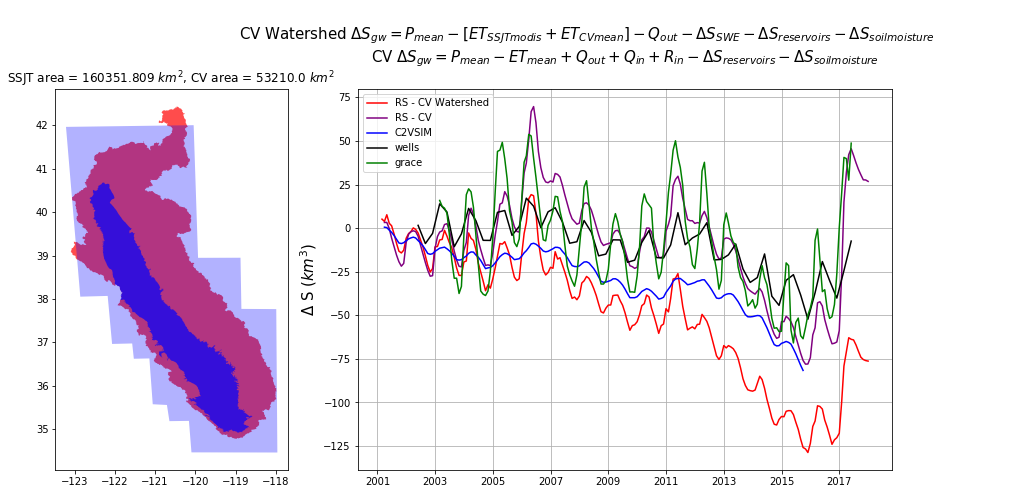

In [13]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
ssjt.plot(ax=axes_1, color = "red", alpha = 0.7)
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
ga.plot(label = "grace footprint", ax=axes_1, color = "blue", alpha = 0.3, legend = True)
axes_1.set_title("SSJT area = {} $km^2$, CV area = {} $km^2$ ".format(round(sa_km3, 3), round(cv_km3, 3)))

axes_4 = plt.subplot(G[0:2, 1:])

axes_4.set_title("""
CV Watershed $\Delta S_{gw} = P_{mean} - [ET_{SSJT modis} + ET_{CV mean}] - Q_{out} - \Delta S_{SWE} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$                 
CV $\Delta S_{gw} = P_{mean} - ET_{mean} + Q_{out} + Q_{in} + R_{in} - \Delta S_{reservoirs} - \Delta S_{soil moisture} $
""", size = 15)
axes_4.plot(df.index, np.cumsum(df.ds), color="red", label = "RS - CV Watershed")
axes_4.plot(cvdf.index, np.cumsum(cvdf.ds), color="purple", label = "RS - CV ")
axes_4.plot(cvdf.index[1:], np.cumsum(cvdf.s.diff()[1:]), color="blue", label = "C2VSIM")
# axes_4.plot(wells.index, wells.ds_km3, color="black", label = "wells1")
axes_4.plot(wells.index, wells.ds_km3_2, color="black", label = "wells")
axes_4.plot(grace.index, grace.adj, color="green", label = "grace")
# axes_4.plot(grace.index, grace.adj, color="green", label = "grace")

axes_4.set_ylabel('$\Delta$ S ($km^3$)', size = 15) 
axes_4.legend()

plt.grid(True)
G.update(wspace=0.3, hspace=0.1) # set the spacing between axes. 
# plt.tight_layout()
plt.show()